# Задача 1
### Оценить месячный retention в оформление заказа с помощью когортного анализа.  
Для начала необходимо прочитать файлы и сделать предобработку.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from operator import attrgetter
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [2]:
customers=pd.read_csv('olist_customers_dataset.csv')

In [3]:
order_items=pd.read_csv('olist_order_items_dataset.csv')

In [4]:
orders=pd.read_csv('olist_orders_dataset.csv')

In [5]:
order_items['shipping_limit_date']=pd.to_datetime(order_items['shipping_limit_date'])

In [6]:
orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']]=orders[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

Для анализа retention мы будем учитывать только статусы заказов, которые означают успешное завершение покупки, такие как delivered.
Теперь рассчитаваем retention.

In [7]:
orders_for_retention=orders.loc[orders.order_status=="delivered"]
orders_for_retention['order_month']=orders_for_retention.order_purchase_timestamp.dt.to_period('M')
orders_for_retention['order_day']=orders_for_retention.order_purchase_timestamp.dt.to_period('D')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
customer_orders=orders_for_retention.merge(customers, on='customer_id')
customer_orders['cohort']=customer_orders.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
customer_orders['cohort_day']=customer_orders.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')
customer_orders['cohort_period']=np.floor((customer_orders.order_day-customer_orders.cohort_day).apply(attrgetter('n'))/30)
df_cohort = customer_orders.groupby(['cohort', 'cohort_period']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()
df_cohort_pivot=df_cohort.pivot(index='cohort', columns='cohort_period', values='n_customers')
cohort_size = df_cohort_pivot.iloc[:, 0]
retention_matrix = df_cohort_pivot.divide(cohort_size, axis=0)
retention_matrix=retention_matrix.drop(columns=[0.0])

In [9]:
retention_matrix.describe()

cohort_period,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
count,19.000000,17.000000,17.000000,16.000000,15.000000,15.000000,13.000000,11.000000,11.000000,10.000000,10.000000,7.000000,8.000000,5.000000,6.000000,4.000000,4.000000,2.000000,1.000000,1.000000
mean,0.003639,0.002927,0.002650,0.002350,0.002235,0.002509,0.002013,0.001846,0.002339,0.002068,0.002653,0.001637,0.002029,0.001651,0.001678,0.001372,0.002312,0.004514,0.003817,0.003817
std,0.001388,0.001298,0.001337,0.000942,0.001369,0.000870,0.001140,0.000847,0.000917,0.001412,0.001525,0.001209,0.001072,0.000763,0.001312,0.000975,0.001291,0.004412,NaN,NaN
min,0.001009,0.000924,0.000443,0.000912,0.000443,0.000937,0.000614,0.000708,0.000283,0.000614,0.000250,0.000614,0.000869,0.000887,0.000614,0.000614,0.000799,0.001395,0.003817,0.003817
25%,0.002859,0.001843,0.001873,0.001595,0.001391,0.002461,0.001159,0.001273,0.001914,0.001159,0.001630,0.000864,0.001121,0.001229,0.000821,0.000818,0.001582,0.002954,0.003817,0.003817
50%,0.003546,0.002691,0.002399,0.002421,0.001900,0.002665,0.001841,0.001479,0.002457,0.001998,0.002681,0.001598,0.001854,0.001317,0.001023,0.001043,0.002316,0.004514,0.003817,0.003817
75%,0.004169,0.003658,0.003451,0.003052,0.002718,0.002876,0.002465,0.002469,0.002662,0.002293,0.003561,0.001669,0.002833,0.002028,0.002382,0.001596,0.003046,0.006074,0.003817,0.003817
max,0.006655,0.005194,0.005579,0.003767,0.005268,0.003817,0.004433,0.003247,0.003817,0.005579,0.005579,0.004184,0.003817,0.002797,0.003817,0.002789,0.003817,0.007634,0.003817,0.003817


медианный retention 1-го месяца составляет 0.0035

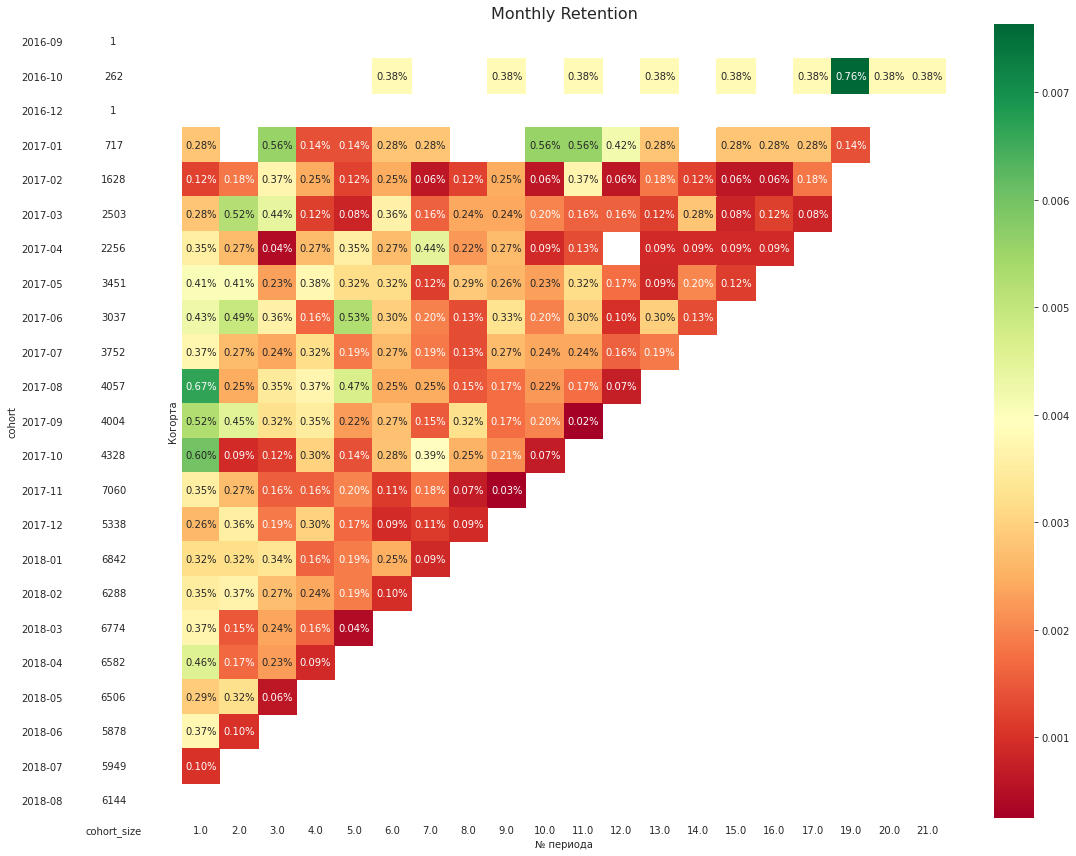

In [10]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.2%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

# Задача 2 
### Определить, существует ли product/market fit у маркетплейса.

Согласно матрице retention всего периода существовавния продукта составляет 0-1%, что говорит о слабом product/market fit. То есть клиент не возвращается в продукт, продукт не закрывает потребности клиента. Пока нет PMF, масштабировать подобный продукт на новые рынки нельзя, так как это может привести к убыткам. Когортный анализ показывает, что каждый месяц в продукт приходит значительное количество новых клиентов. Со временем компании может не хватить денег на привлечение новых клиентов, что приведет к снижению их количества. Высокий уровень оттока на ранних этапах взаимодействия с продуктом указывает на потенциальные проблемы с его качеством, функциональностью или соответствием ожиданиям клиентов.
Низкий уровень удержания клиентов может свидетельствовать о том, что маркетплейс не предоставляет достаточной ценности или уникальности по сравнению с конкурентами. Это может быть связано с недостаточной дифференциацией продукта, проблемами с качеством обслуживания или отсутствием необходимых функций и услуг.

# Задача 3
### Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

#### Первая метрика должна отражать рост объёма продаж маркетплейса (метрика- объём продаж по месяцам)

In [11]:
gmv=orders_for_retention.merge(order_items[['order_id', 'price']], on='order_id')
gmv_data=gmv.groupby('order_month', as_index=False).price.sum()
gmv_data['order_month']=gmv_data['order_month'].astype(str)

Text(0.5, 1.0, 'Изменение объема продаж по месяцам')

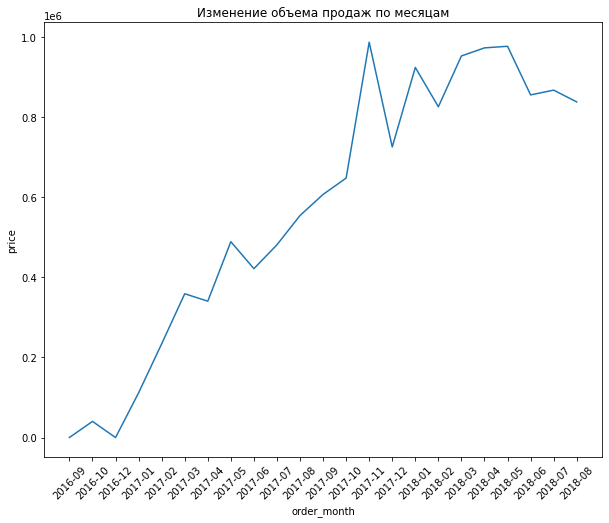

In [12]:
plt.figure(figsize=(10,8))
sns.lineplot(data=gmv_data, x='order_month', y='price')
plt.xticks(rotation=45)
plt.title("Изменение объема продаж по месяцам")

#### Вторая — показывать количество уникальных пользователей, которые совершают хотя бы один заказ в продукте в течение месяца (метритка - количество платящих клиентов)

Text(0.5, 1.0, 'Количество платящих клиентов')

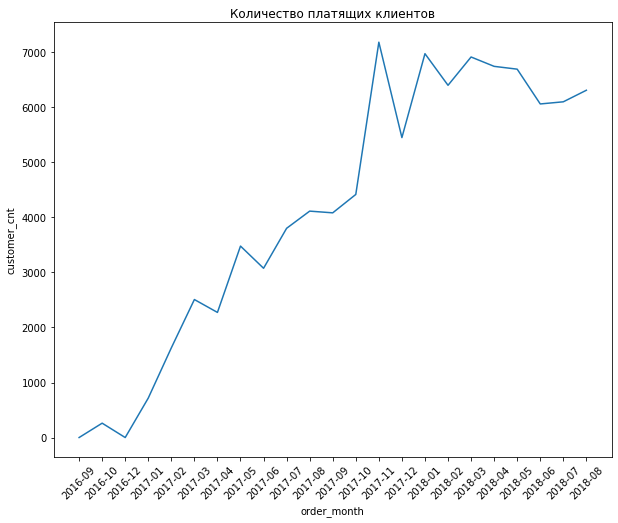

In [13]:
count_customer=customer_orders.groupby('order_month', as_index=False).customer_unique_id.nunique().rename(columns={'customer_unique_id' :'customer_cnt'})
count_customer['order_month']=count_customer['order_month'].astype(str)
plt.figure(figsize=(10,8))
sns.lineplot(data=count_customer, x='order_month', y='customer_cnt')
plt.xticks(rotation=45)
plt.title("Количество платящих клиентов")

#### Третья — отражать заинтересованность новых клиентов в продукте (даже если вы не можете посчитать ее на имеющихся у вас данных)  (метритка - КОНВЕРСИЯ В ПЕРВУЮ ПОКУПКУ)

#### Четвёртая — отражать вовлеченность клиента в продолжение использования продукта (метритка - RETENTION)

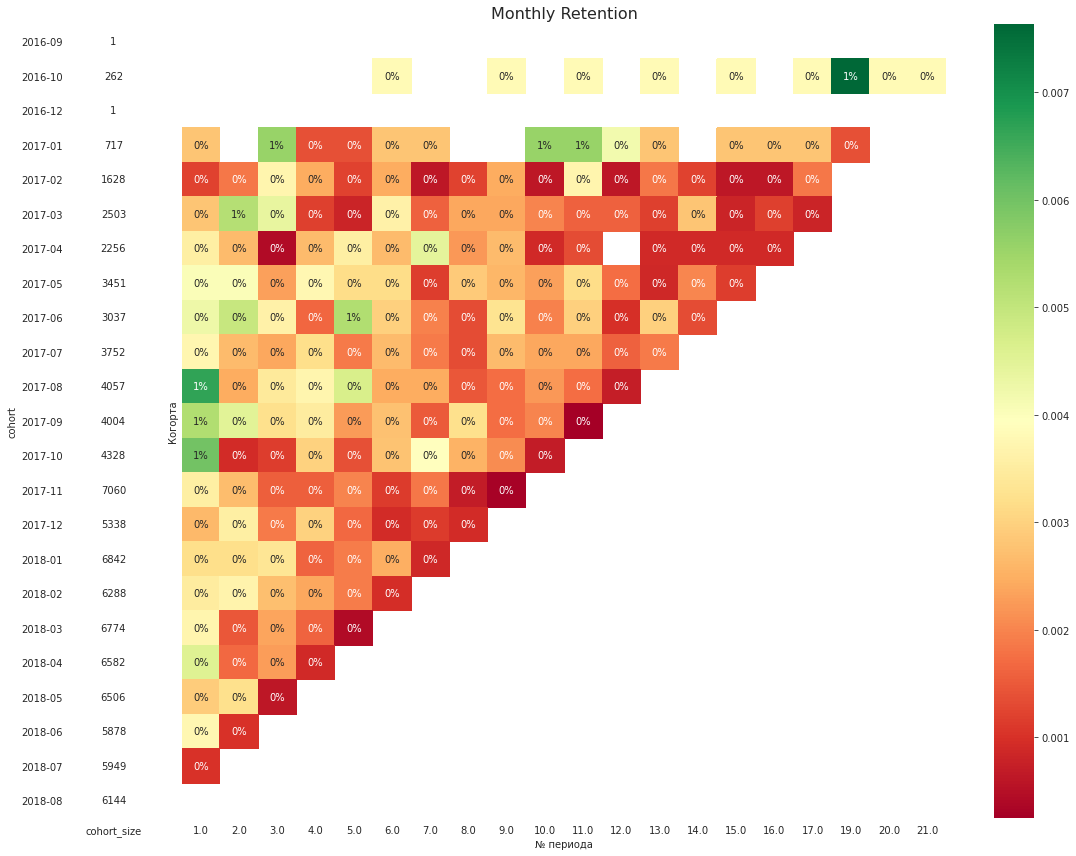

In [14]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

#### Пятая — отражать денежное выражение вовлеченности клиента (метрика - Средняя выручка на платящего пользователя)

In [15]:
order_all_info=gmv.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')

In [16]:
arppu=order_all_info.groupby('order_month').agg(revenue=('price','sum'), users=('customer_unique_id','nunique')).reset_index()

In [17]:
arppu['ARPPU']=arppu['revenue']/arppu['users']

In [18]:
arppu['order_month']=arppu['order_month'].astype(str)

Text(0.5, 1.0, 'Средняя выручка на платящего пользователя')

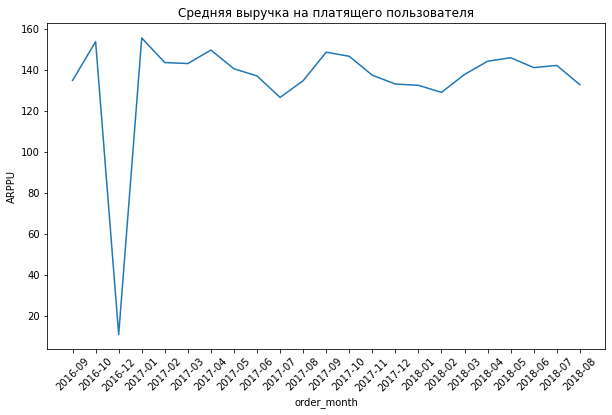

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=arppu, x='order_month', y='ARPPU')
plt.xticks(rotation=45)
plt.title("Средняя выручка на платящего пользователя")

# Задача 4
### Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

#### Гипотеза 1. Если исправим баг в системе процессинга заказов, то клиентам не придется сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится.

Для расчета Impact по этой гипотезе можно посчитать количество заказов, который остались в статусе отмены. Заказом в статусе отмены будем считать статусы: canceled, unavailable

In [20]:
order_since06_2017=orders.query('order_purchase_timestamp>="2017-06"').merge(customers, on='customer_id')

In [21]:
#Количество отмененных заказов
canc_order=order_since06_2017.query('order_status=="canceled" or order_status=="unavailable"')
canc_order.order_id.nunique()

974

974 пользователя (impact 5 для 1 гипотезы)

#### Гипотеза 2. Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счет повторных заказов.

Для расчета Impact по этой гипотезе можно посчитать количество заказов, которые были доставлены с опозданием. Конверсию в повторный заказ возьмем равной 0.0035.

In [22]:
order_since06_2017.query('order_estimated_delivery_date < order_delivered_customer_date and order_status=="delivered"'
                        ).groupby('customer_unique_id',as_index=False).order_id.nunique().order_id.count()*0.0035

25.3575

25 пользователей (impact 1 для 2 гипотезы)

#### Гипотеза 3. Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при выполнении заказа, вследствие чего количество заказов увеличится за счет повторных заказов.  

Для расчета Impact по этой гипотезе можно посчитать количество заказов, где клиент сделал только единичный заказ. Конверсию в повторный заказ возьмем равной 0.0035.

In [23]:
order_since06_2017.groupby('customer_unique_id').order_id.nunique().sort_values().reset_index().query('order_id==1').order_id.sum()

82559

Возможное количество повторных заказов:

In [25]:
82559*0.0035

288.9565

288 пользователей (impact 3 для 3 гипотезы)

При сравнении по фреймворку ICE из 3 гипотез выигрывает гипотеза 1.

# Задача 5
### Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

#### Гипотеза 1. Если исправим баг в системе процессинга заказов, то клиентам не придется сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится.

Метрики, на которые повлияет гипотеза 1:
- целевая - Количество доставленных заказов. Необходимо оценить, увеличилось ли количество успешных доставок после исправления бага. 
- proxi - Конверсия в доставку товара до покупателя. Нужна для определения снижения числа отмен после исправления бага.
- guardrail - конверсия в оформление. Если снизится сильно, значит есть проблема.